In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt

In [2]:
import celltypist
from celltypist import models

In [3]:
## set working directory
os.chdir("/data1/niehu/ibd_public_data_20210821/analysis_20220111/02.integrate/T_NK/all_CD4_V2/")

In [4]:
adata0 = sc.read_h5ad("./all_CD4.n10.h5ad")

In [5]:
## read data
adata = sc.read_h5ad("./all_CD4.bySample.n10.bbknn_umap_leiden_marker.res1.5.h5ad")
adata.raw = adata0.raw.to_adata()
adata = sc.pp.subsample(adata, fraction=1., copy=True)

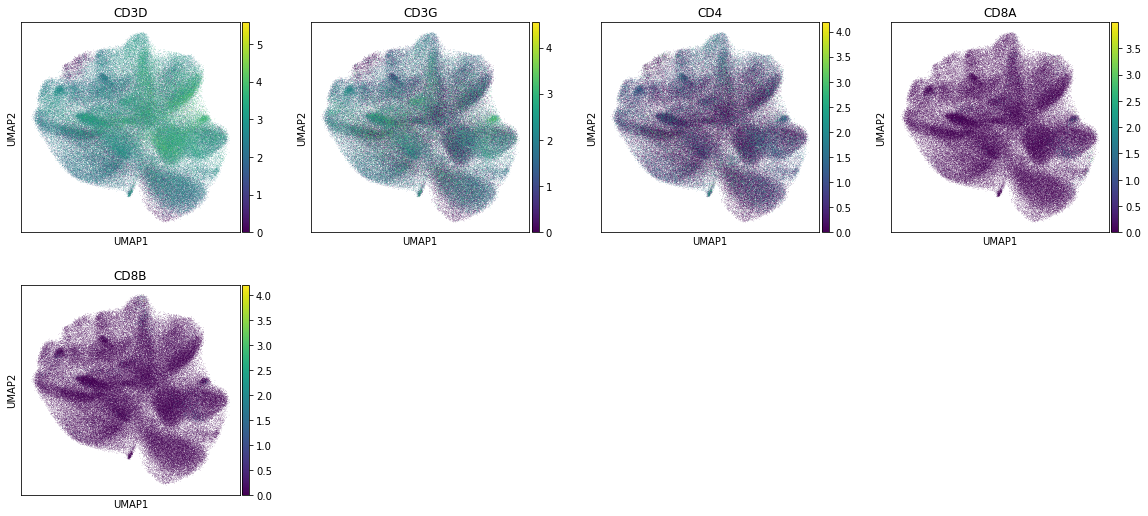

In [6]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=["CD3D","CD3G","CD4","CD8A","CD8B"])

In [7]:
## add meta data
meta_data = pd.read_csv("/home/niehu/niehu/ibd_public_data_20210821/analysis_20220111/01.preprocess/cell_meta/ibd_meta_data_cells.csv", header=0)
meta_data.index = meta_data.cellName

select = meta_data[meta_data.index.isin(adata.obs.index.to_list())]
select = select.loc[adata.obs.index,:]

adata.obs["location2"] = pd.Categorical(select.location2)
adata.obs["location1"] = pd.Categorical(select.location1)
adata.obs["developmentStage"] = pd.Categorical(select.developmentStage)

/home/niehu/niehu/soft/anaconda3/envs/jupyterlab/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3012: DtypeWarning: Columns (3,4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


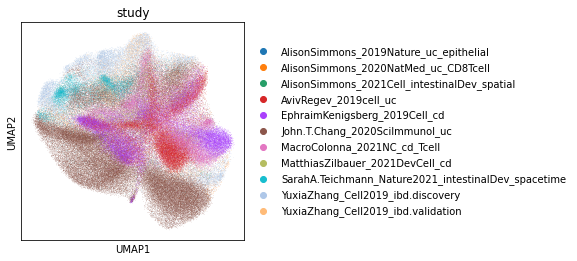

In [8]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=["study"])

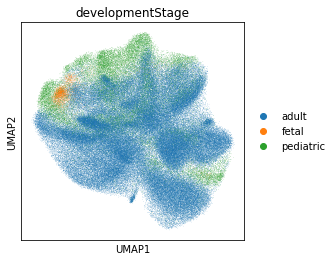

In [9]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=["developmentStage"])

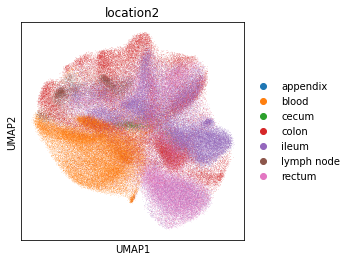

In [10]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=["location2"])

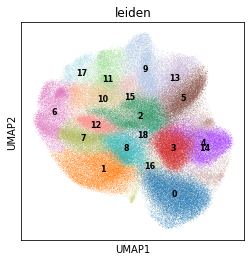

In [11]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color='leiden', legend_loc='on data', title='leiden', frameon=True, legend_fontsize = 8)

In [23]:
# check
select = np.logical_and( adata.obs.leiden.isin(['8']), adata.obs.location2.isin(['colon']))
adata.obs.loc[select].sampleName.value_counts()

N661.LPA2            1060
N661.LPB1             976
N661.LPA1             637
N661.LPB2             308
N44.LPA                19
                     ... 
GSM4483695              0
GSM4483696              0
GSM4483697              0
GSM4761136              0
intestinalDev_3_6       0
Name: sampleName, Length: 258, dtype: int64

In [22]:
# check
adata.obs.loc[adata.obs.leiden.isin(['1'])].location2.value_counts()

blood         15803
rectum          715
colon           401
ileum           164
lymph node      104
appendix          1
cecum             1
Name: location2, dtype: int64

In [12]:
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting = True, over_clustering = 'leiden')

👀 Detected scaled expression in the input data, will try the `.raw` attribute
🔬 Input data has 188965 cells and 15813 genes
🔗 Matching reference genes in the model
🧬 1934 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


In [13]:
adata = predictions.to_adata()

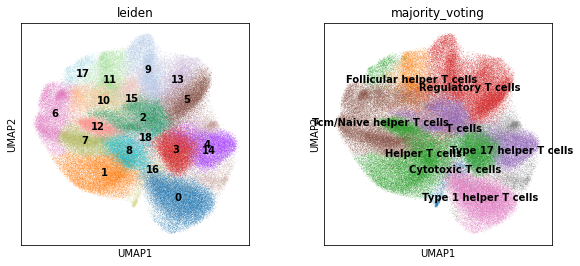

In [14]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color = ['leiden', 'majority_voting'], legend_loc = 'on data')

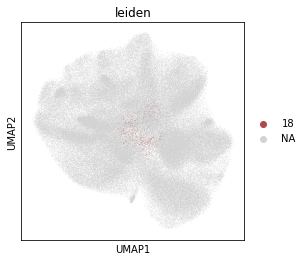

In [15]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color='leiden', groups=['18'])

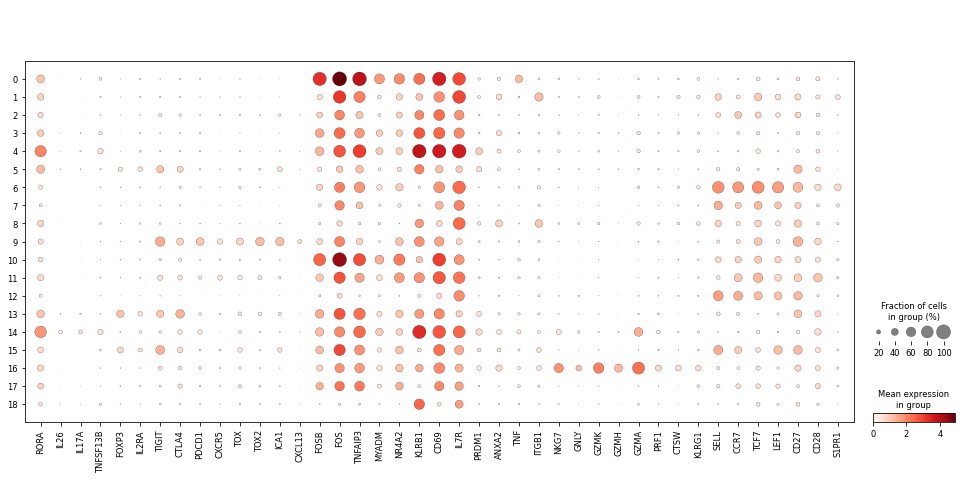

In [16]:
#sc.pl.dotplot(adata[np.logical_not(adata.obs.leiden.isin(['14','19','7','5','11','0','2','4']))], [ #"CD3D","CD3G","CD4","CD8A","CD8B",
#sc.pl.dotplot(adata[adata.obs.leiden.isin(['6','7','8','12','3','14'])], [ "CD3D","CD3G","CD4","CD8A","CD8B",
sc.pl.dotplot(adata, [ # "CD3D","CD3G","CD4","CD8A","CD8B",
    "RORA", "IL26", "IL17A","TNFSF13B", # Th17
    "FOXP3","IL2RA","TIGIT","CTLA4", # Treg
    "PDCD1","CXCR5","TOX","TOX2","ICA1", "CXCL13", # Tfh
    "FOSB","FOS","TNFAIP3","MYADM","NR4A2",
    "KLRB1","CD69","IL7R","PRDM1",
    "ANXA2","TNF","ITGB1",
    "NKG7","GNLY","GZMK","GZMH","GZMA","PRF1","CTSW","KLRG1", # Tem
    "SELL","CCR7","TCF7","LEF1","CD27","CD28","S1PR1", # Tn
], groupby="leiden")

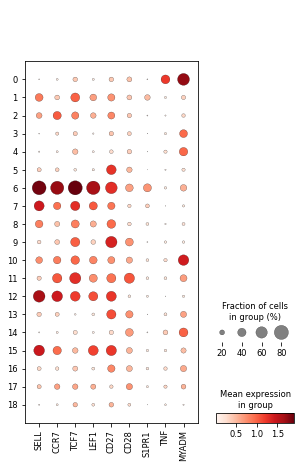

In [17]:
sc.pl.dotplot(adata, [
    "SELL","CCR7","TCF7","LEF1","CD27","CD28","S1PR1",
    "TNF","MYADM"
], groupby="leiden")

In [18]:
## CD4+ Tn => C6/C7/C12, SELL/CCR7/TCF7/LEF1/CD27/CD28 high, GZMA/GZMK/NKG7 low
## CD4+ Tem => C16, CX3CR1 low, ANXA1/2 high, GZMA, GZMK, CCL5 high √
## CD4+ Th17 => C14, IL17A, RORA, GZMA, NKG7 high √
## CD4+ Tfh => C9, TOX/TOX2/PDCD1/CXCL13 high √ 
## CD4+ Treg => C5/C13/C15, FOXP3/CTLA4 high √
## CD4+ Tcm-tissue or blood => C1/C2/C8/C18 √
## CD4+ Trm => C0/C3/C4, SELL/CCR7/TCF7/LEF1 low, MYADM/KLRB1/IL7R/PTGER4 high, colon, rectum, ileum √
## CD4+ activated T=> C10/C11/C17 √

adata.obs["label"] = "T_cells"

select = adata.obs[ adata.obs.leiden.isin(['6','7','12']) ].index.to_list()
adata.obs.loc[select, 'label'] = 'CD4+ Tn'

select = adata.obs[ adata.obs.leiden.isin(['16']) ].index.to_list()
adata.obs.loc[select, 'label'] = 'CD4+ Tem'

select = adata.obs[ adata.obs.leiden.isin(['14']) ].index.to_list()
adata.obs.loc[select, 'label'] = 'CD4+ Th17'

select = adata.obs[ adata.obs.leiden.isin(['9']) ].index.to_list()
adata.obs.loc[select, 'label'] = 'CD4+ Tfh'

select = adata.obs[ adata.obs.leiden.isin(['5','13','15']) ].index.to_list()
adata.obs.loc[select, 'label'] = 'CD4+ Treg'

select = adata.obs[ adata.obs.leiden.isin(['2','18']) ].index.to_list()
adata.obs.loc[select, 'label'] = 'CD4+ tissue-Tcm'

select = adata.obs[ adata.obs.leiden.isin(['1','8',]) ].index.to_list()
adata.obs.loc[select, 'label'] = 'CD4+ blood-Tcm'

select = adata.obs[ adata.obs.leiden.isin(['0']) ].index.to_list()
adata.obs.loc[select, 'label'] = 'CD4+ TNF_high Trm'

select = adata.obs[ adata.obs.leiden.isin(['3','4']) ].index.to_list()
adata.obs.loc[select, 'label'] = 'CD4+ TNF_low Trm'

select = adata.obs[ adata.obs.leiden.isin(['10','11','17']) ].index.to_list()
adata.obs.loc[select, 'label'] = 'CD4+ activated T'

In [19]:
adata.obs.label = pd.Categorical(adata.obs.label)
newOrder = ["CD4+ Tn","CD4+ Tem", "CD4+ blood-Tcm","CD4+ tissue-Tcm","CD4+ TNF_high Trm","CD4+ TNF_low Trm",
            "CD4+ Tfh","CD4+ Treg","CD4+ Th17","CD4+ activated T"]
## set leves for the factor (label or leiden)
adata.obs.label = adata.obs.label.cat.set_categories(newOrder)

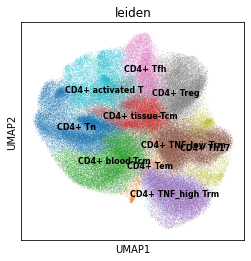

In [20]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color='label', legend_loc='on data', title='leiden', frameon=True, legend_fontsize = 8)

In [21]:
adata.obs["major"] = "CD4T"

In [22]:
adata = adata.raw.to_adata()

In [23]:
del adata.obs["location1"]
del adata.obs["location2"]
del adata.obs["developmentStage"]

In [24]:
adata.write_h5ad("CD4T.clean.h5ad")

... storing 'major' as categorical


In [25]:
adata.write_loom("CD4T.clean.loom", write_obsm_varm=True)

In [26]:
## done